<a href="https://colab.research.google.com/github/yasinsoylu1997/TEZZ2/blob/main/hybr%C4%B1t_my_models_son.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import seaborn as sns
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers
import pandas as pd
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Activation,Concatenate
from tensorflow.keras.layers import BatchNormalization
from keras.preprocessing.image import load_img,img_to_array,ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.metrics import classification_report,confusion_matrix
import keras
import keras.utils
from keras import utils as np_utils
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
#!pip install visualkeras
import numpy as np 
import matplotlib.pyplot as plt
import glob
import cv2

from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
import os
!pip install visualkeras
!pip install catboost


In [4]:
labels = ['Lung_Opacity','COVID','Normal','Viral Pneumonia']

In [5]:
X = []
y = []
image_size = 32
for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/tezz3/COVID-19_Radiography_Dataset_masked',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X.append(img)
        y.append(i)

        
X = np.array(X)
y = np.array(y)

100%|██████████| 1345/1345 [00:07<00:00, 170.75it/s]


In [6]:
from imblearn.over_sampling import RandomOverSampler
reshaped_X = X.reshape(X.shape[0],-1)

#oversampling
oversample = RandomOverSampler()
oversampled_X, oversampled_y  = oversample.fit_resample(reshaped_X , y)

# reshaping X back to the first dims
new_X = oversampled_X.reshape(-1,32,32,3)
oversampled_y


array(['Lung_Opacity', 'Lung_Opacity', 'Lung_Opacity', ...,
       'Viral Pneumonia', 'Viral Pneumonia', 'Viral Pneumonia'],
      dtype='<U15')

In [7]:
train_images, test_images,train_labels, test_labels = train_test_split(new_X , oversampled_y , test_size=0.25, random_state=42,shuffle=True)

In [8]:
train_images=train_images[:1500]
test_images=test_images[:1500]
train_labels=train_labels[:1500]
test_labels=test_labels[:1500]


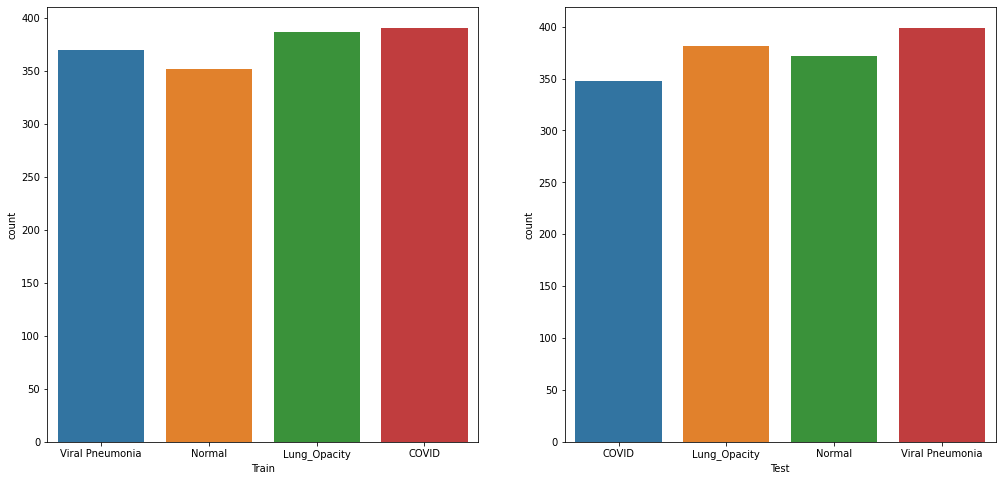

In [9]:
plt.figure(figsize = (17,8));
lis = ['Train', 'Test']
for i,j in enumerate([train_labels, test_labels]):
    plt.subplot(1,2, i+1);
    sns.countplot(x = j);
    plt.xlabel(lis[i])

In [10]:
train_images = train_images / 255.0
test_images = test_images / 255.0

In [11]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(test_labels)
test_labels_encoded = le.transform(test_labels)
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)

In [12]:
#Split data into test and train datasets (already split but assigning to meaningful convention)
x_train, y_train, x_test, y_test = train_images, train_labels_encoded, test_images, test_labels_encoded

In [13]:
#One hot encode y values for neural network. 
from tensorflow.keras.utils import to_categorical
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

In [14]:
y_test_one_hot

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       ...,
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]], dtype=float32)

In [15]:
activation = 'relu'

feature_extractor = Sequential()
feature_extractor.add(Conv2D(32, 3, activation = activation, padding = 'same', input_shape = (32, 32, 3)))
feature_extractor.add(BatchNormalization())

feature_extractor.add(Conv2D(32, 3, activation = activation, padding = 'same', kernel_initializer = 'he_uniform'))
feature_extractor.add(BatchNormalization())
feature_extractor.add(MaxPooling2D())

feature_extractor.add(Conv2D(64, 3, activation = activation, padding = 'same', kernel_initializer = 'he_uniform'))
feature_extractor.add(BatchNormalization())

feature_extractor.add(Conv2D(64, 3, activation = activation, padding = 'same', kernel_initializer = 'he_uniform'))
feature_extractor.add(BatchNormalization())
feature_extractor.add(MaxPooling2D())

feature_extractor.add(Flatten())

In [16]:
#Add layers for deep learning prediction
x = feature_extractor.output  
x = Dense(128, activation = activation, kernel_initializer = 'he_uniform')(x)
prediction_layer = Dense(4, activation = 'softmax')(x)

In [17]:
# Make a new model combining both feature extractor and x
cnn_model = Model(inputs=feature_extractor.input, outputs=prediction_layer)
cnn_model.compile(optimizer='adam',loss = 'categorical_crossentropy', metrics = ['accuracy'])
print(cnn_model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0     

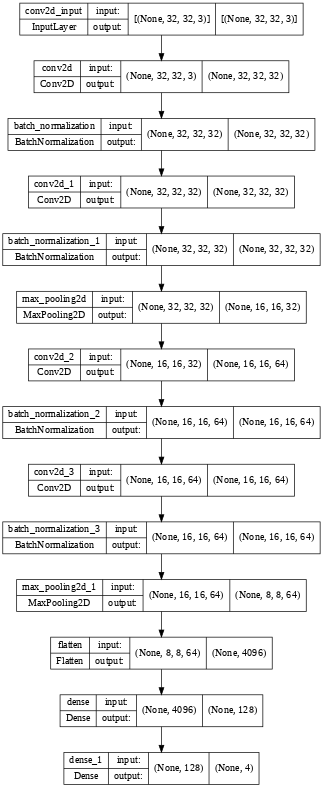

In [18]:
from keras.utils.vis_utils import plot_model

plot_model(cnn_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True,dpi=50)

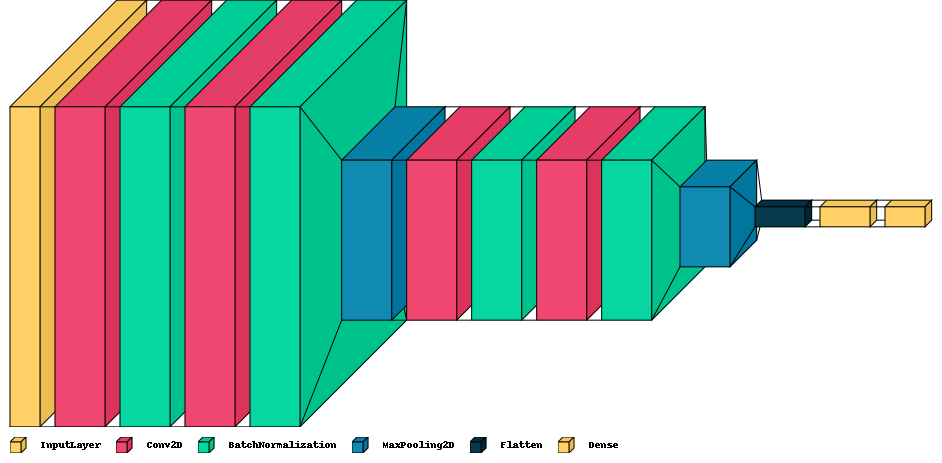

<Figure size 144x144 with 0 Axes>

In [19]:
import visualkeras
from PIL import ImageFont
plt.figure(figsize=(2, 2))
visualkeras.layered_view(cnn_model, legend=True,spacing=15,scale_xy = 10 , scale_z = 10, max_z = 50) 

In [20]:
checkpoint = ModelCheckpoint("cnn.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 4, min_delta = 0.001,mode='auto',verbose=1)
early_stop=tf.keras.callbacks.EarlyStopping( monitor="val_accuracy",patience=4,verbose=1,mode="auto",)

In [21]:
#Train the CNN model
history = cnn_model.fit(x_train, y_train_one_hot, epochs=100, validation_data = (x_test, y_test_one_hot),batch_size=8,callbacks=[checkpoint,reduce_lr,early_stop])

Epoch 1/100
188/188 [==============================] - ETA: 0s - loss: 1.2418 - accuracy: 0.5700
Epoch 1: val_accuracy improved from -inf to 0.25400, saving model to cnn.h5
188/188 [==============================] - 24s 121ms/step - loss: 1.2418 - accuracy: 0.5700 - val_loss: 3.2338 - val_accuracy: 0.2540 - lr: 0.0010
Epoch 2/100
187/188 [============================>.] - ETA: 0s - loss: 0.7938 - accuracy: 0.6484
Epoch 2: val_accuracy improved from 0.25400 to 0.25800, saving model to cnn.h5
188/188 [==============================] - 23s 122ms/step - loss: 0.7931 - accuracy: 0.6487 - val_loss: 3.4873 - val_accuracy: 0.2580 - lr: 0.0010
Epoch 3/100
187/188 [============================>.] - ETA: 0s - loss: 0.6787 - accuracy: 0.7066
Epoch 3: val_accuracy improved from 0.25800 to 0.58733, saving model to cnn.h5
188/188 [==============================] - 16s 87ms/step - loss: 0.6783 - accuracy: 0.7067 - val_loss: 1.1473 - val_accuracy: 0.5873 - lr: 0.0010
Epoch 4/100
187/188 [==============

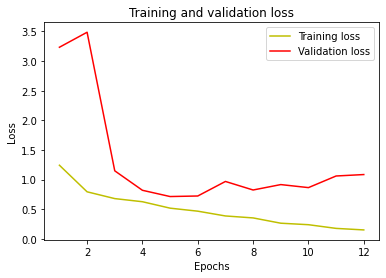

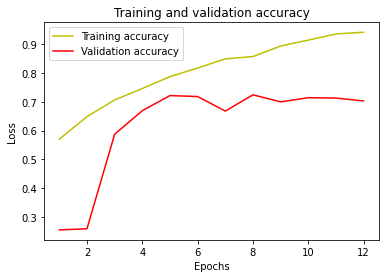

In [22]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


#plot the training and validation accuracy and loss at each epoch
loss = history.history['accuracy']
val_loss = history.history['val_accuracy']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training accuracy')
plt.plot(epochs, val_loss, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [23]:
from keras.models import load_model

cnn_model = load_model('cnn.h5')

In [24]:
prediction_NN = cnn_model.predict(x_test)
prediction_NN = np.argmax(prediction_NN, axis=-1)
prediction_NN = le.inverse_transform(prediction_NN)

[[212  66  66   4]
 [ 66 275  34   6]
 [ 82  44 230  16]
 [ 15   3  11 370]]


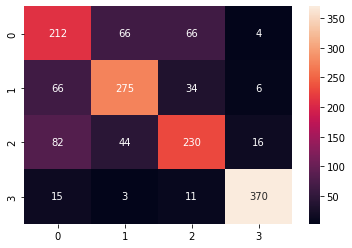

In [25]:
#Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, prediction_NN)
print(cm)
sns.heatmap(cm, annot=True,fmt="d")

In [26]:
#Now, let us use features from convolutional network for ML
X_for_model = feature_extractor.predict(x_train) 

In [27]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score

def cross_val(model):
    pred = cross_val_score(model, X_for_model, y_train)
    return pred.mean()

def print_evaluate(true, predicted):  
    mae = metrics.mean_absolute_error(y_test, predicted)
    mse = metrics.mean_squared_error(y_test, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(y_test, predicted))
    r2_square = metrics.r2_score(y_test, predicted)
    Accuracy= metrics.accuracy_score(y_test,predicted)

    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square)
    print('Accuracy_mymodel', Accuracy)



    print('__________________________________')
    
def evaluate(true, predicted):
    mae = metrics.mean_absolute_error(y_test, predicted)
    mse = metrics.mean_squared_error(y_test, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(y_test, predicted))
    r2_square = metrics.r2_score(y_test, predicted)
    Accuracy= metrics.accuracy_score(y_test,predicted)

    return mae, mse, rmse, r2_square, Accuracy

#  KNeighborsClassifier

In [28]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn_model = knn.fit(X_for_model, y_train)
knn_model

KNeighborsClassifier()

In [29]:
X_test_feature = feature_extractor.predict(x_test)
#Now predict using the trained RF model. 
predicted = knn_model.predict(X_test_feature)

In [30]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, predicted)

Test set evaluation:
_____________________________________
MAE: 0.48133333333333334
MSE: 0.76
RMSE: 0.8717797887081347
R2 Square 0.3889181922270395
Accuracy_mymodel 0.6546666666666666
__________________________________


In [31]:
results_df = pd.DataFrame(data=[["KNeighborsClassifier", *evaluate(y_test, predicted) ]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy_mymodel'])
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy_mymodel
0,KNeighborsClassifier,0.481333,0.76,0.87178,0.388918,0.654667


In [32]:
print(classification_report(y_test,predicted))

              precision    recall  f1-score   support

           0       0.49      0.56      0.52       348
           1       0.60      0.59      0.60       381
           2       0.59      0.50      0.54       372
           3       0.92      0.93      0.93       399

    accuracy                           0.65      1500
   macro avg       0.65      0.65      0.65      1500
weighted avg       0.66      0.65      0.65      1500



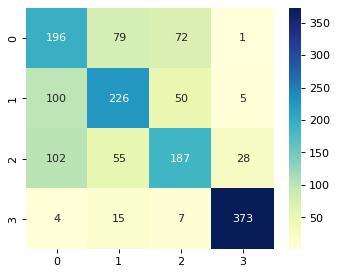

In [33]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(5, 4), dpi=80)
cm = confusion_matrix(y_test,predicted)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# svc

In [34]:
from sklearn.svm import SVC
svm_model = SVC(kernel = "linear")
svm_model = svm_model.fit(X_for_model, y_train)
svm_model

SVC(kernel='linear')

In [35]:
X_test_feature = feature_extractor.predict(x_test)
#Now predict using the trained RF model. 
predicted = svm_model.predict(X_test_feature)
#Inverse le transform to get original label back. 


print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, predicted)

Test set evaluation:
_____________________________________
MAE: 0.39666666666666667
MSE: 0.6313333333333333
RMSE: 0.7945648704374825
R2 Square 0.4923732702096547
Accuracy_mymodel 0.7186666666666667
__________________________________


In [36]:
results_df_2 = pd.DataFrame(data=[["SVC", *evaluate(y_test, predicted)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy_mymodel' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy_mymodel
0,KNeighborsClassifier,0.481333,0.760000,0.871780,0.388918,0.654667
1,SVC,0.396667,0.631333,0.794565,0.492373,0.718667


In [37]:
print(classification_report(y_test,predicted))

              precision    recall  f1-score   support

           0       0.55      0.56      0.56       348
           1       0.68      0.71      0.70       381
           2       0.67      0.64      0.65       372
           3       0.95      0.94      0.94       399

    accuracy                           0.72      1500
   macro avg       0.71      0.71      0.71      1500
weighted avg       0.72      0.72      0.72      1500



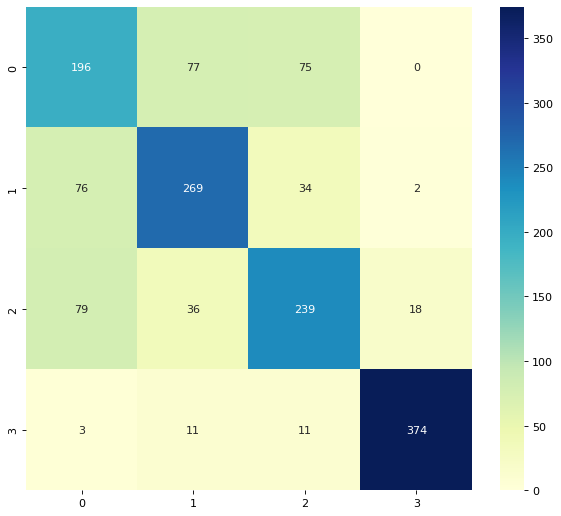

In [38]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(9, 8), dpi=80)
cm = confusion_matrix(y_test,predicted)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# RBF SVC


In [39]:
from sklearn.svm import SVC

svc_model = SVC(kernel = "rbf").fit(X_for_model, y_train)
svc_model = svc_model.fit(X_for_model, y_train)
svc_model

SVC()

In [40]:
X_test_feature = feature_extractor.predict(x_test)
#Now predict using the trained RF model. 
predicted = svc_model.predict(X_test_feature)
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, predicted)

Test set evaluation:
_____________________________________
MAE: 0.3473333333333333
MSE: 0.5513333333333333
RMSE: 0.7425182377109221
R2 Square 0.556697671027861
Accuracy_mymodel 0.754
__________________________________


In [41]:
results_df_2 = pd.DataFrame(data=[["RBF SVC", *evaluate(y_test, predicted) ]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy_mymodel'])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy_mymodel
0,KNeighborsClassifier,0.481333,0.760000,0.871780,0.388918,0.654667
1,SVC,0.396667,0.631333,0.794565,0.492373,0.718667
2,RBF SVC,0.347333,0.551333,0.742518,0.556698,0.754000


In [42]:
print(classification_report(y_test,predicted))

              precision    recall  f1-score   support

           0       0.61      0.64      0.62       348
           1       0.72      0.73      0.73       381
           2       0.71      0.66      0.68       372
           3       0.95      0.97      0.96       399

    accuracy                           0.75      1500
   macro avg       0.75      0.75      0.75      1500
weighted avg       0.75      0.75      0.75      1500



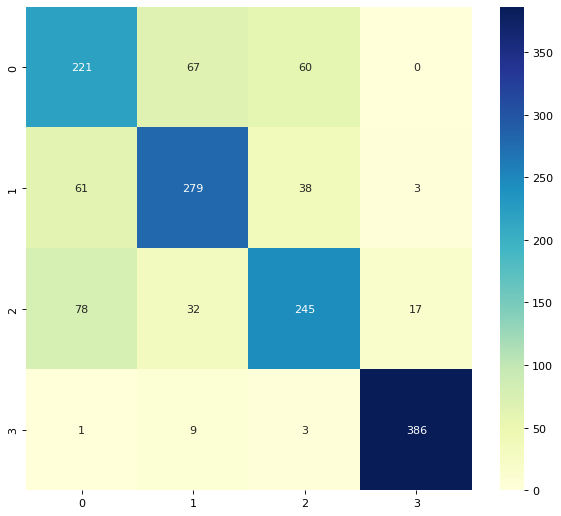

In [43]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(9, 8), dpi=80)
cm = confusion_matrix(y_test,predicted)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# DecisionTreeClassifier

In [44]:
from sklearn.tree import DecisionTreeClassifier
cart_model = DecisionTreeClassifier()
cart_model = cart_model.fit(X_for_model, y_train)
cart_model

DecisionTreeClassifier()

In [45]:
X_test_feature = feature_extractor.predict(x_test)
#Now predict using the trained RF model. 
predicted = cart_model.predict(X_test_feature)



print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, predicted)

Test set evaluation:
_____________________________________
MAE: 0.6153333333333333
MSE: 1.0486666666666666
RMSE: 1.024044269876389
R2 Square 0.15681431260801149
Accuracy_mymodel 0.5806666666666667
__________________________________


In [46]:
results_df_2 = pd.DataFrame(data=[["DecisionTreeClassifier", *evaluate(y_test, predicted)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy_mymodel' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy_mymodel
0,KNeighborsClassifier,0.481333,0.760000,0.871780,0.388918,0.654667
1,SVC,0.396667,0.631333,0.794565,0.492373,0.718667
2,RBF SVC,0.347333,0.551333,0.742518,0.556698,0.754000
3,DecisionTreeClassifier,0.615333,1.048667,1.024044,0.156814,0.580667


In [47]:
print(classification_report(y_test,predicted))

              precision    recall  f1-score   support

           0       0.42      0.49      0.45       348
           1       0.53      0.50      0.51       381
           2       0.53      0.45      0.48       372
           3       0.82      0.86      0.84       399

    accuracy                           0.58      1500
   macro avg       0.57      0.57      0.57      1500
weighted avg       0.58      0.58      0.58      1500



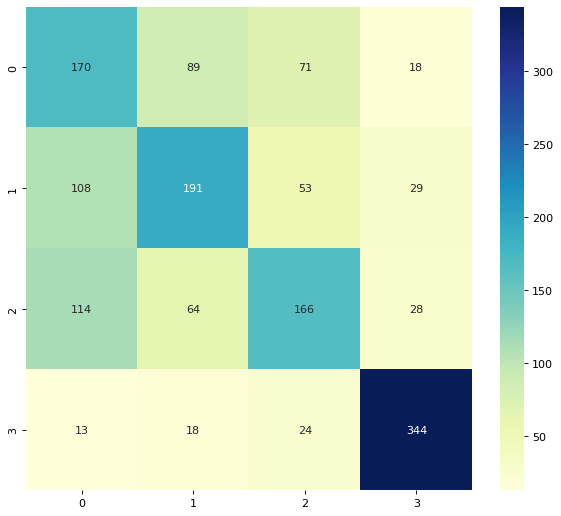

In [48]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(9, 8), dpi=80)
cm = confusion_matrix(y_test,predicted)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# Lojistik regresyon

In [49]:
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression()
lr_model = lr_model.fit(X_for_model, y_train)
lr_model

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()

In [50]:
X_test_feature = feature_extractor.predict(x_test)
#Now predict using the trained RF model. 
predicted = lr_model.predict(X_test_feature)



print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, predicted)

Test set evaluation:
_____________________________________
MAE: 0.4046666666666667
MSE: 0.658
RMSE: 0.8111719916269299
R2 Square 0.47093180327025264
Accuracy_mymodel 0.7173333333333334
__________________________________


In [51]:
results_df_2 = pd.DataFrame(data=[["LogisticRegression", *evaluate(y_test, predicted)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy_mymodel' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy_mymodel
0,KNeighborsClassifier,0.481333,0.760000,0.871780,0.388918,0.654667
1,SVC,0.396667,0.631333,0.794565,0.492373,0.718667
2,RBF SVC,0.347333,0.551333,0.742518,0.556698,0.754000
3,DecisionTreeClassifier,0.615333,1.048667,1.024044,0.156814,0.580667
4,LogisticRegression,0.404667,0.658000,0.811172,0.470932,0.717333


In [52]:
print(classification_report(y_test,predicted))

              precision    recall  f1-score   support

           0       0.56      0.58      0.57       348
           1       0.69      0.72      0.70       381
           2       0.66      0.60      0.63       372
           3       0.93      0.94      0.94       399

    accuracy                           0.72      1500
   macro avg       0.71      0.71      0.71      1500
weighted avg       0.72      0.72      0.72      1500



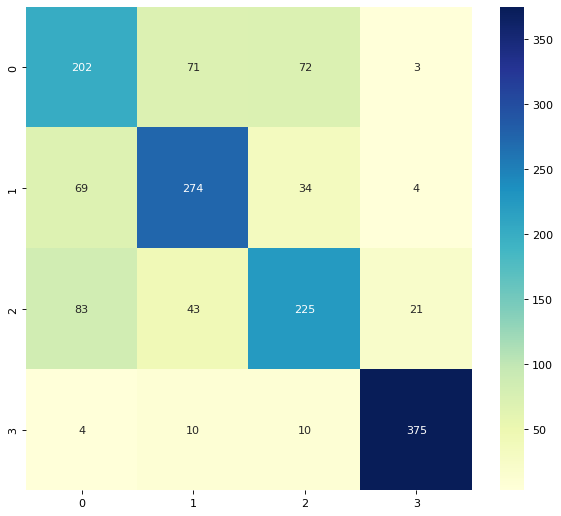

In [53]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(9, 8), dpi=80)
cm = confusion_matrix(y_test,predicted)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# SGDClassifier

In [54]:
from sklearn.linear_model import SGDClassifier

SGD_model = SGDClassifier()
SGD_model = SGD_model.fit(X_for_model, y_train)
SGD_model

SGDClassifier()

In [55]:
X_test_feature = feature_extractor.predict(x_test)
#Now predict using the trained RF model. 
predicted = SGD_model.predict(X_test_feature)



print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, predicted)

Test set evaluation:
_____________________________________
MAE: 0.40066666666666667
MSE: 0.6446666666666667
RMSE: 0.8029113691228109
R2 Square 0.4816525367399537
Accuracy_mymodel 0.718
__________________________________


In [56]:
results_df_2 = pd.DataFrame(data=[["SGDClassifier", *evaluate(y_test, predicted)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy_mymodel' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy_mymodel
0,KNeighborsClassifier,0.481333,0.760000,0.871780,0.388918,0.654667
1,SVC,0.396667,0.631333,0.794565,0.492373,0.718667
2,RBF SVC,0.347333,0.551333,0.742518,0.556698,0.754000
3,DecisionTreeClassifier,0.615333,1.048667,1.024044,0.156814,0.580667
4,LogisticRegression,0.404667,0.658000,0.811172,0.470932,0.717333
5,SGDClassifier,0.400667,0.644667,0.802911,0.481653,0.718000


In [57]:
print(classification_report(y_test,predicted))

              precision    recall  f1-score   support

           0       0.57      0.56      0.57       348
           1       0.69      0.72      0.70       381
           2       0.65      0.62      0.63       372
           3       0.93      0.94      0.94       399

    accuracy                           0.72      1500
   macro avg       0.71      0.71      0.71      1500
weighted avg       0.72      0.72      0.72      1500



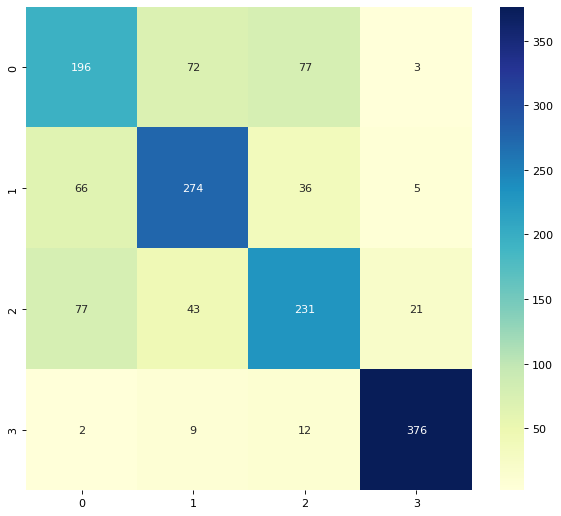

In [58]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(9, 8), dpi=80)
cm = confusion_matrix(y_test,predicted)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# GradientBoostingClassifier

In [59]:
from sklearn.ensemble import GradientBoostingClassifier

GBC_model = GradientBoostingClassifier()
GBC_model = GBC_model.fit(X_for_model, y_train)
GBC_model

GradientBoostingClassifier()

In [60]:
X_test_feature = feature_extractor.predict(x_test)
#Now predict using the trained RF model. 
predicted = GBC_model.predict(X_test_feature)



print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, predicted)

Test set evaluation:
_____________________________________
MAE: 0.41333333333333333
MSE: 0.676
RMSE: 0.8221921916437787
R2 Square 0.4564588130861562
Accuracy_mymodel 0.7146666666666667
__________________________________


In [61]:
results_df_2 = pd.DataFrame(data=[["GradientBoostingClassifier", *evaluate(y_test, predicted)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy_mymodel' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy_mymodel
0,KNeighborsClassifier,0.481333,0.760000,0.871780,0.388918,0.654667
1,SVC,0.396667,0.631333,0.794565,0.492373,0.718667
2,RBF SVC,0.347333,0.551333,0.742518,0.556698,0.754000
3,DecisionTreeClassifier,0.615333,1.048667,1.024044,0.156814,0.580667
4,LogisticRegression,0.404667,0.658000,0.811172,0.470932,0.717333
5,SGDClassifier,0.400667,0.644667,0.802911,0.481653,0.718000
6,GradientBoostingClassifier,0.413333,0.676000,0.822192,0.456459,0.714667


In [62]:
print(classification_report(y_test,predicted))

              precision    recall  f1-score   support

           0       0.55      0.58      0.56       348
           1       0.70      0.70      0.70       381
           2       0.65      0.60      0.63       372
           3       0.93      0.94      0.94       399

    accuracy                           0.71      1500
   macro avg       0.71      0.71      0.71      1500
weighted avg       0.72      0.71      0.71      1500



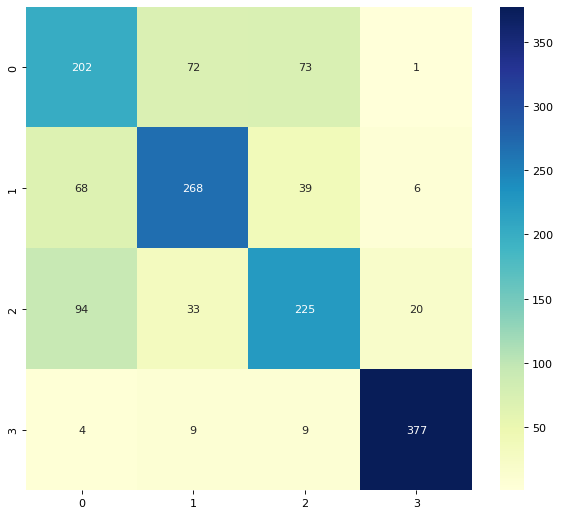

In [63]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(9, 8), dpi=80)
cm = confusion_matrix(y_test,predicted)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# LGBMClassifier

In [64]:
from lightgbm import LGBMClassifier

LGBM_model = LGBMClassifier()
LGBM_model = LGBM_model.fit(X_for_model, y_train)
LGBM_model

LGBMClassifier()

In [65]:
X_test_feature = feature_extractor.predict(x_test)
#Now predict using the trained RF model. 
predicted = LGBM_model.predict(X_test_feature)



print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, predicted)

Test set evaluation:
_____________________________________
MAE: 0.37066666666666664
MSE: 0.5853333333333334
RMSE: 0.7650708028237213
R2 Square 0.5293598006801234
Accuracy_mymodel 0.736
__________________________________


In [66]:
results_df_2 = pd.DataFrame(data=[["LGBMClassifier", *evaluate(y_test, predicted)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy_mymodel' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy_mymodel
0,KNeighborsClassifier,0.481333,0.760000,0.871780,0.388918,0.654667
1,SVC,0.396667,0.631333,0.794565,0.492373,0.718667
2,RBF SVC,0.347333,0.551333,0.742518,0.556698,0.754000
3,DecisionTreeClassifier,0.615333,1.048667,1.024044,0.156814,0.580667
4,LogisticRegression,0.404667,0.658000,0.811172,0.470932,0.717333
5,SGDClassifier,0.400667,0.644667,0.802911,0.481653,0.718000
6,GradientBoostingClassifier,0.413333,0.676000,0.822192,0.456459,0.714667
7,LGBMClassifier,0.370667,0.585333,0.765071,0.529360,0.736000


In [67]:
print(classification_report(y_test,predicted))

              precision    recall  f1-score   support

           0       0.59      0.59      0.59       348
           1       0.70      0.72      0.71       381
           2       0.69      0.64      0.66       372
           3       0.93      0.97      0.95       399

    accuracy                           0.74      1500
   macro avg       0.73      0.73      0.73      1500
weighted avg       0.73      0.74      0.73      1500



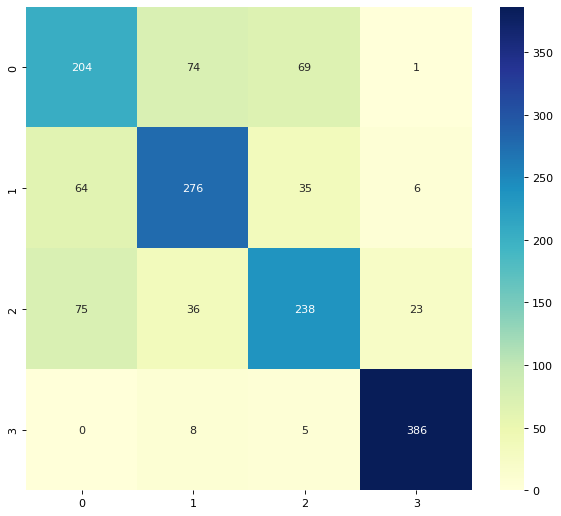

In [68]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(9, 8), dpi=80)
cm = confusion_matrix(y_test,predicted)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# XGBClassifier

In [69]:
from xgboost.sklearn import XGBClassifier

XGBC_model = XGBClassifier()
XGBC_model = XGBC_model.fit(X_for_model, y_train)
XGBC_model

XGBClassifier(objective='multi:softprob')

In [70]:
X_test_feature = feature_extractor.predict(x_test)
#Now predict using the trained RF model. 
predicted = XGBC_model.predict(X_test_feature)



print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, predicted)

Test set evaluation:
_____________________________________
MAE: 0.4066666666666667
MSE: 0.6733333333333333
RMSE: 0.8205689083394114
R2 Square 0.45860295978009646
Accuracy_mymodel 0.7213333333333334
__________________________________


In [71]:
results_df_2 = pd.DataFrame(data=[["XGBClassifier", *evaluate(y_test, predicted)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy_mymodel' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy_mymodel
0,KNeighborsClassifier,0.481333,0.760000,0.871780,0.388918,0.654667
1,SVC,0.396667,0.631333,0.794565,0.492373,0.718667
2,RBF SVC,0.347333,0.551333,0.742518,0.556698,0.754000
3,DecisionTreeClassifier,0.615333,1.048667,1.024044,0.156814,0.580667
4,LogisticRegression,0.404667,0.658000,0.811172,0.470932,0.717333
5,SGDClassifier,0.400667,0.644667,0.802911,0.481653,0.718000
6,GradientBoostingClassifier,0.413333,0.676000,0.822192,0.456459,0.714667
7,LGBMClassifier,0.370667,0.585333,0.765071,0.529360,0.736000
8,XGBClassifier,0.406667,0.673333,0.820569,0.458603,0.721333


In [72]:
print(classification_report(y_test,predicted))

              precision    recall  f1-score   support

           0       0.55      0.58      0.57       348
           1       0.71      0.70      0.71       381
           2       0.66      0.63      0.65       372
           3       0.93      0.94      0.94       399

    accuracy                           0.72      1500
   macro avg       0.72      0.72      0.72      1500
weighted avg       0.72      0.72      0.72      1500



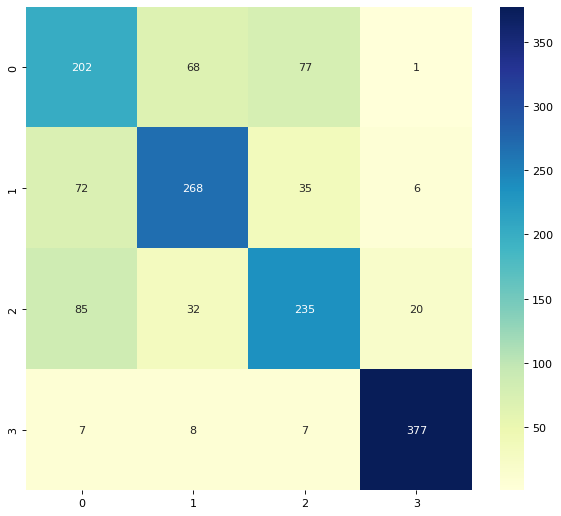

In [73]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(9, 8), dpi=80)
cm = confusion_matrix(y_test,predicted)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# RandomForestClassifier

In [74]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier()
rf_model = rf_model.fit(X_for_model, y_train)
rf_model

RandomForestClassifier()

In [75]:
X_test_feature = feature_extractor.predict(x_test)
#Now predict using the trained RF model. 
predicted = rf_model.predict(X_test_feature)

In [76]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, predicted)

Test set evaluation:
_____________________________________
MAE: 0.4066666666666667
MSE: 0.6613333333333333
RMSE: 0.8132240363721016
R2 Square 0.4682516199028274
Accuracy_mymodel 0.7166666666666667
__________________________________


In [77]:
results_df_2 = pd.DataFrame(data=[["RandomForestClassifier", *evaluate(y_test, predicted)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy_mymodel' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy_mymodel
0,KNeighborsClassifier,0.481333,0.760000,0.871780,0.388918,0.654667
1,SVC,0.396667,0.631333,0.794565,0.492373,0.718667
2,RBF SVC,0.347333,0.551333,0.742518,0.556698,0.754000
3,DecisionTreeClassifier,0.615333,1.048667,1.024044,0.156814,0.580667
4,LogisticRegression,0.404667,0.658000,0.811172,0.470932,0.717333
5,SGDClassifier,0.400667,0.644667,0.802911,0.481653,0.718000
6,GradientBoostingClassifier,0.413333,0.676000,0.822192,0.456459,0.714667
7,LGBMClassifier,0.370667,0.585333,0.765071,0.529360,0.736000
8,XGBClassifier,0.406667,0.673333,0.820569,0.458603,0.721333
9,RandomForestClassifier,0.406667,0.661333,0.813224,0.468252,0.716667


In [78]:
print(classification_report(y_test,predicted))

              precision    recall  f1-score   support

           0       0.56      0.59      0.57       348
           1       0.69      0.71      0.70       381
           2       0.68      0.58      0.63       372
           3       0.90      0.96      0.93       399

    accuracy                           0.72      1500
   macro avg       0.71      0.71      0.71      1500
weighted avg       0.71      0.72      0.71      1500



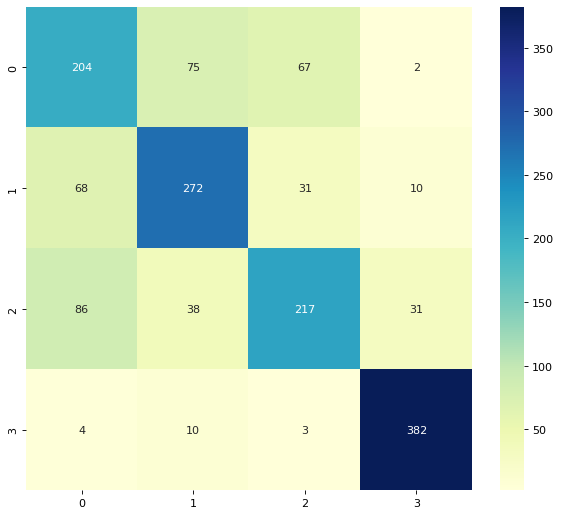

In [79]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(9, 8), dpi=80)
cm = confusion_matrix(y_test,predicted)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# GaussianNB

In [80]:
from sklearn.naive_bayes import GaussianNB


GB_model = GaussianNB()
GB_model = GB_model.fit(X_for_model, y_train)
GB_model

GaussianNB()

In [81]:
X_test_feature = feature_extractor.predict(x_test)
#Now predict using the trained RF model. 
predicted = GB_model.predict(X_test_feature)

In [82]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, predicted)

Test set evaluation:
_____________________________________
MAE: 0.5226666666666666
MSE: 0.9013333333333333
RMSE: 0.9493857663422879
R2 Square 0.27527841744820825
Accuracy_mymodel 0.6493333333333333
__________________________________


In [83]:
results_df_2 = pd.DataFrame(data=[["GaussianNB", *evaluate(y_test, predicted)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy_mymodel' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy_mymodel
0,KNeighborsClassifier,0.481333,0.760000,0.871780,0.388918,0.654667
1,SVC,0.396667,0.631333,0.794565,0.492373,0.718667
2,RBF SVC,0.347333,0.551333,0.742518,0.556698,0.754000
3,DecisionTreeClassifier,0.615333,1.048667,1.024044,0.156814,0.580667
4,LogisticRegression,0.404667,0.658000,0.811172,0.470932,0.717333
5,SGDClassifier,0.400667,0.644667,0.802911,0.481653,0.718000
6,GradientBoostingClassifier,0.413333,0.676000,0.822192,0.456459,0.714667
7,LGBMClassifier,0.370667,0.585333,0.765071,0.529360,0.736000
8,XGBClassifier,0.406667,0.673333,0.820569,0.458603,0.721333
9,RandomForestClassifier,0.406667,0.661333,0.813224,0.468252,0.716667


In [84]:
print(classification_report(y_test,predicted))

              precision    recall  f1-score   support

           0       0.49      0.48      0.49       348
           1       0.62      0.69      0.65       381
           2       0.62      0.51      0.56       372
           3       0.82      0.89      0.85       399

    accuracy                           0.65      1500
   macro avg       0.64      0.64      0.64      1500
weighted avg       0.64      0.65      0.64      1500



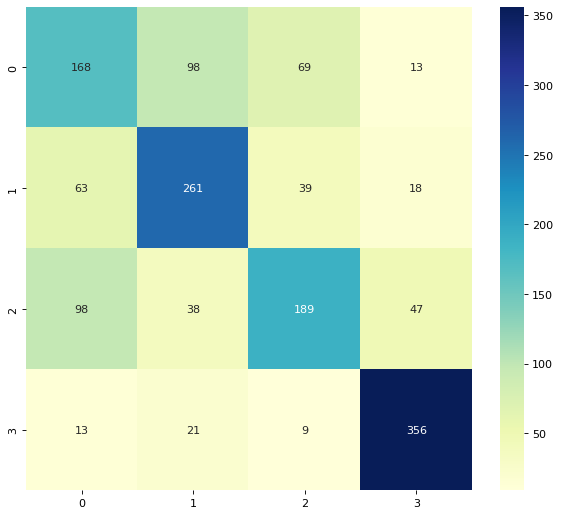

In [85]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(9, 8), dpi=80)
cm = confusion_matrix(y_test,predicted)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

In [87]:
modeller = [rf_model,GB_model,XGBC_model,LGBM_model,GBC_model,SGD_model,lr_model,cart_model,svc_model,svm_model,knn_model]

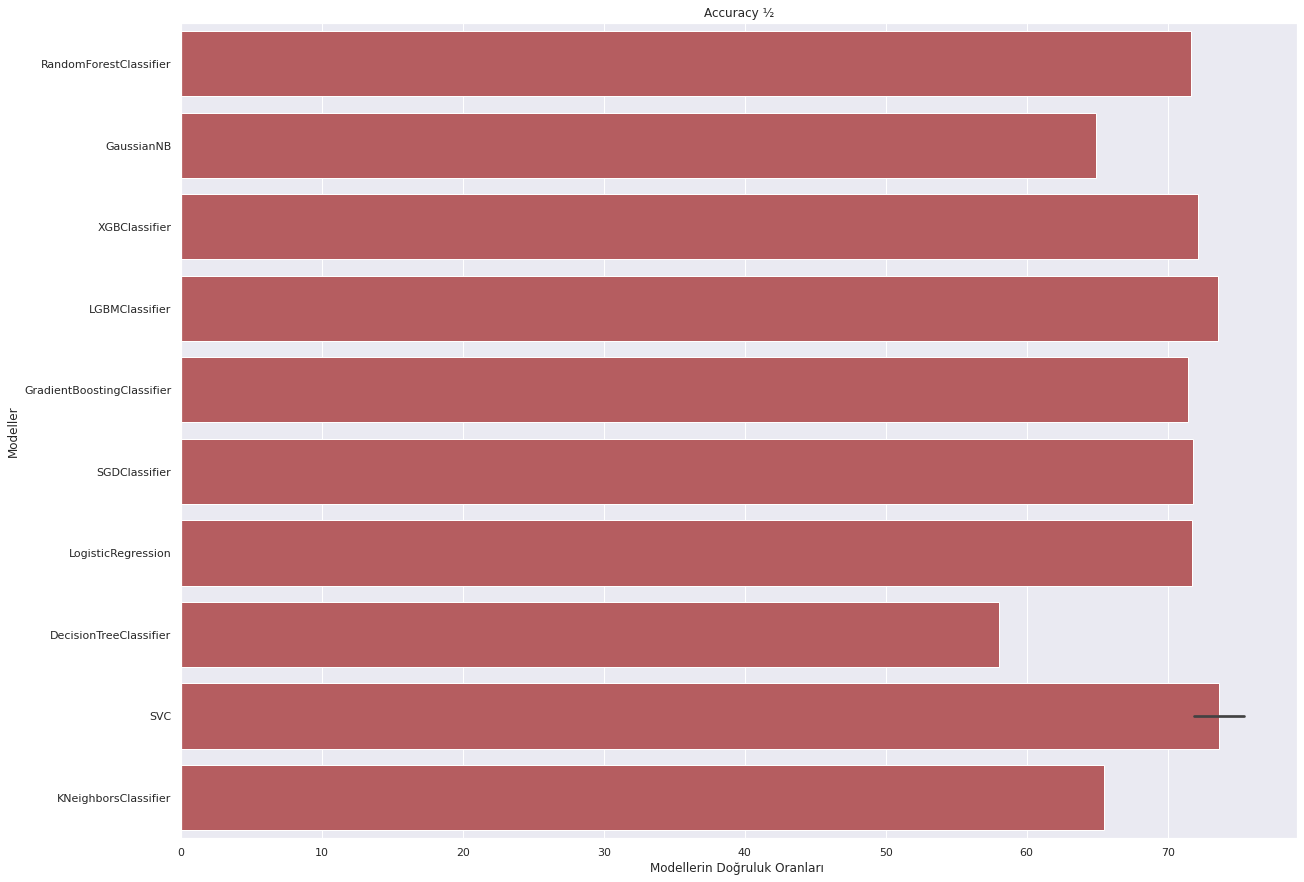

In [97]:
sonuc = []

sonuclar = pd.DataFrame(columns= ["Modeller","Accuracy"])

for model in modeller:
    isimler = model.__class__.__name__
    y_pred = model.predict(X_test_feature)
    dogruluk = accuracy_score(y_test, y_pred)    
    sonuc = pd.DataFrame([[isimler, dogruluk*100]], columns= ["Modeller","Accuracy"])
    sonuclar = sonuclar.append(sonuc)
    
sns.set(rc={'figure.figsize':(20,15)})
sns.barplot(x= 'Accuracy', y = 'Modeller', data=sonuclar, color="r")
plt.xlabel('Modellerin Doğruluk Oranları ')
plt.title('Accuracy ½');  

In [95]:
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy_mymodel
0,KNeighborsClassifier,0.481333,0.760000,0.871780,0.388918,0.654667
1,SVC,0.396667,0.631333,0.794565,0.492373,0.718667
2,RBF SVC,0.347333,0.551333,0.742518,0.556698,0.754000
3,DecisionTreeClassifier,0.615333,1.048667,1.024044,0.156814,0.580667
4,LogisticRegression,0.404667,0.658000,0.811172,0.470932,0.717333
5,SGDClassifier,0.400667,0.644667,0.802911,0.481653,0.718000
6,GradientBoostingClassifier,0.413333,0.676000,0.822192,0.456459,0.714667
7,LGBMClassifier,0.370667,0.585333,0.765071,0.529360,0.736000
8,XGBClassifier,0.406667,0.673333,0.820569,0.458603,0.721333
9,RandomForestClassifier,0.406667,0.661333,0.813224,0.468252,0.716667
